In [1]:
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
import random
random.seed(2022)
startDate = datetime.datetime(2015, 1, 1)
endDate = datetime.datetime(2022, 11, 30)
SPY = yf.download("SPY", start=startDate, end = endDate, interval='1d')
SPY

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,206.380005,206.880005,204.179993,205.429993,174.806793,121465900
2015-01-05,204.169998,204.369995,201.350006,201.720001,171.649796,169632600
2015-01-06,202.089996,202.720001,198.860001,199.820007,170.033051,209151400
2015-01-07,201.419998,202.720001,200.880005,202.309998,172.151886,125346700
2015-01-08,204.009995,206.160004,203.990005,205.899994,175.206757,147217800
...,...,...,...,...,...,...
2022-11-22,396.630005,400.070007,395.149994,399.899994,392.112457,60429000
2022-11-23,399.549988,402.929993,399.309998,402.420013,394.583405,68261600
2022-11-25,401.829987,402.910004,401.540009,402.329987,394.495148,30545400


Date
2015-01-05         NaN
2015-01-06         NaN
2015-01-07         NaN
2015-01-08         NaN
2015-01-09    1.535975
                ...   
2022-11-22    0.836347
2022-11-23    0.710682
2022-11-25    0.654096
2022-11-28    1.105329
2022-11-29    1.092861
Name: Adj Close, Length: 1991, dtype: float64


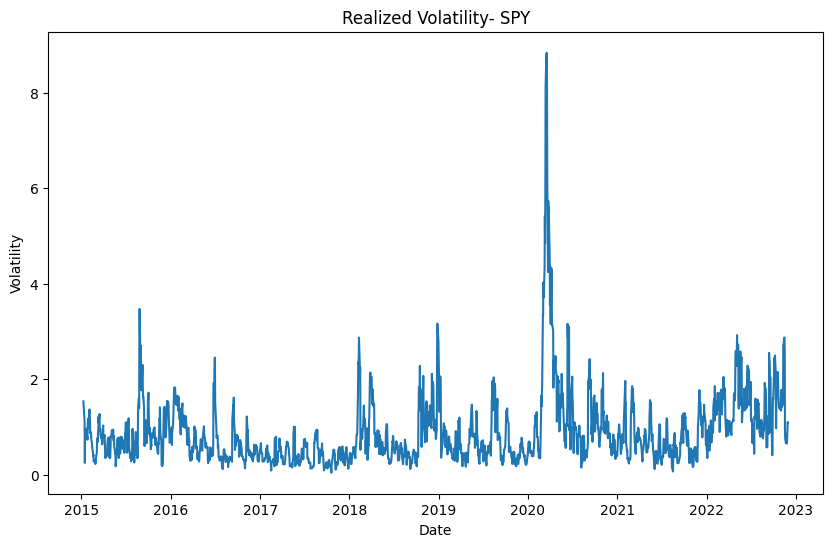

In [3]:
n=229
ret = 100 * (SPY.pct_change()[1:]['Adj Close'])
# Measures the percent change between closing prices of the stock
realized_vol = ret.rolling(5).std()
#Calculates the standard deviation of every 5 values stored in ret
print(realized_vol)
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- SPY')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
realized_vol = pd.DataFrame(realized_vol)
returns = ret ** 2
returns = returns.reset_index()
del returns['Date']
X = realized_vol.copy()
X['Returns'] = list(returns['Adj Close'])
X = X[4:].copy()
X = X.reset_index(drop = True)
realized_vol = realized_vol[4:]
X

,Adj Close,Returns
0,1.535975,0.642234
1,1.303450,0.613594
2,1.201050,0.079130
3,1.089917,0.364455
4,0.247928,0.839142
...,...,...
1982,0.836347,1.810917
1983,0.710682,0.397105
1984,0.654096,0.000500
1985,1.105329,2.546278


In [55]:
vol_forcaster = MLPRegressor(learning_rate_init = 0.05, max_iter = 2000, hidden_layer_sizes = 500, random_state=1)
grid = { 
    "alpha" : [0.0004,0.0002,0.0006], "activation": ["identity","logistic","relu","tanh"]}
clf = RandomizedSearchCV(vol_forcaster, grid)
clf.fit(X.iloc[:-n].values,realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
print(clf.best_estimator_,clf.best_score_)
predicted_vol = clf.predict(X.iloc[-n:])
predicted_vol = pd.DataFrame(predicted_vol)
predicted_vol.index = ret.iloc[-n:].index

MLPRegressor(activation='identity', alpha=0.0006, hidden_layer_sizes=500,
             learning_rate_init=0.05, max_iter=2000, random_state=1) 0.80089893484199


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


In [56]:
mse_out = mse(realized_vol.iloc[-n:]/100,predicted_vol/100)
r2_out = r2(realized_vol.iloc[-n:]/100,predicted_vol/100)
print(mse_out)
print(r2_out)

1.068756231498002e-06
0.9662198661299417


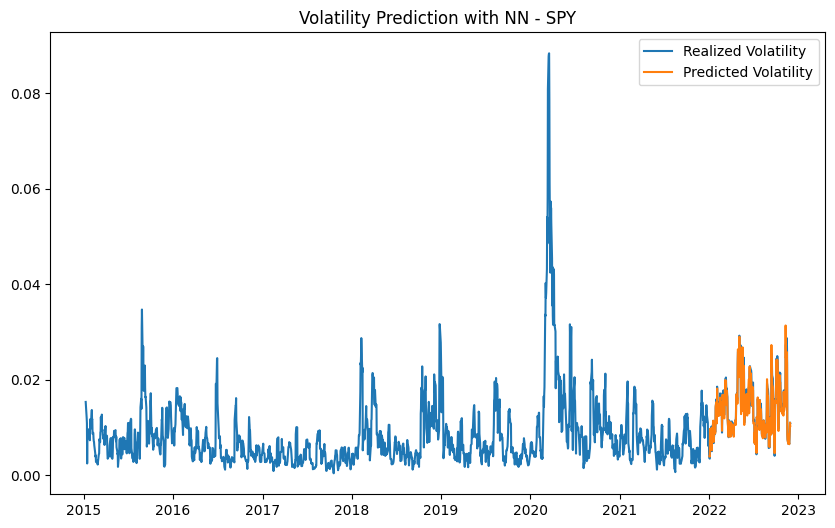

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predicted_vol / 100, label='Predicted Volatility')
plt.title('Volatility Prediction with NN - SPY', fontsize=12)
plt.legend()
plt.show()

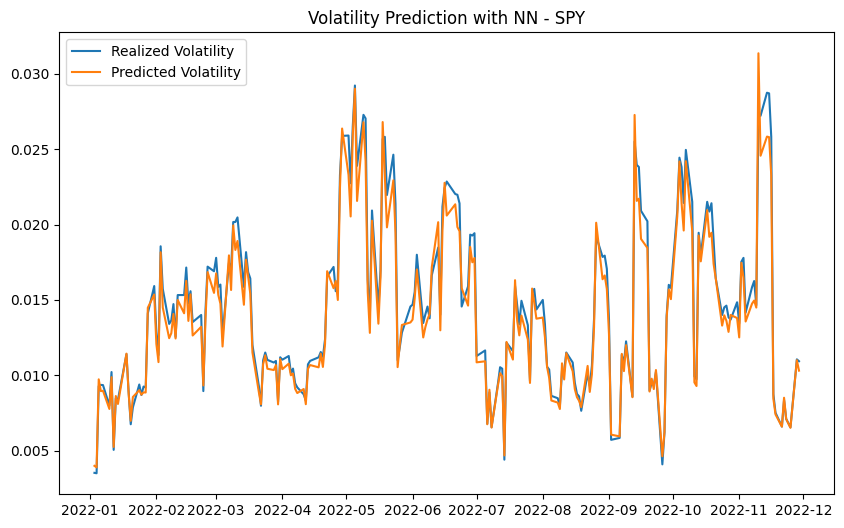

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol[-n:] / 100, label='Realized Volatility')
plt.plot(predicted_vol / 100, label='Predicted Volatility')
plt.title('Volatility Prediction with NN - SPY', fontsize=12)
plt.legend()
plt.show()